# Narrow-band high frequency signals

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts

print_figs = True

---

## Low frequency signal

In [1]:
models = ['exponential', 'gaussian']
U = {m: hf.high_frequency_signal(model=m) for m in models}

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/aponte/.miniconda3/envs/stats/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-cd80e13c3a41>", line 2, in <module>
    U = {m: hf.high_frequency_signal(model=m) for m in models}
  File "<ipython-input-2-cd80e13c3a41>", line 2, in <dictcomp>
    U = {m: hf.high_frequency_signal(model=m) for m in models}
  File "/Users/aponte/Code/synthetic_stats/sstats/hfreq.py", line 340, in __init__
    analytical_spectrum=spectrum,
  File "/Users/aponte/Code/synthetic_stats/sstats/hfreq.py", line 121, in __init__
    self.update_spectrum(spectrum=analytical_spectrum)
  File "/Users/aponte/Code/synthetic_stats/sstats/hfreq.py", line 140, in update_spectrum
    self.spectrum = _fourier_transform(self.autocorrelation, tau, omega/(2*pi))
  File "/Users/aponte/Code/synthetic_stats/sstats/hfreq.py", line 103, in _fourier_transform
    return i

TypeError: object of type 'NoneType' has no len()

In [ ]:
for m, u in U.items():
    print(m+":")
    display(u.autocorrelation)

In [ ]:
for m, u in U.items():
    print(m+":")
    display(u.spectrum)

### check Parseval

In [5]:
# check Parseval: !!! 2 pi factor required
from sympy import oo, pi

for m, u in U.items():
    _E = u.spectrum.subs({u.p["sigma"]: 2/u.p["T"]}) # hack, required (atan issues with sympy)
    _I = _E.integrate((u.omega, 0, oo)) *2 /2/pi
    #_I = u.spectrum.integrate((u.omega, -oo, oo)) /2/pi # not working for exp
    print(m+":")
    display(_I.simplify())

exponential:


U**2

gaussian:


U**2

### value at frequency 0

In [6]:
# value at 0 frequency
for m, u in U.items():
    _E0 = u.spectrum.subs({u.omega:0})
    print(m+":")
    display(_E0.simplify())

exponential:


2*T*U**2/(T**2*sigma**2 + 1)

gaussian:


sqrt(pi)*T*U**2*exp(-T**2*sigma**2/4)

/Users/aponte/.miniconda3/envs/stats/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


Text(0.5, 1.0, 'non-stationary time scale T= 10.0d')

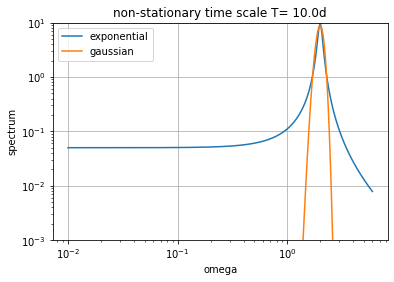

In [7]:
# for multiple parameter values:
T = 10.

ax = plt.subplot(111)

for m, u in U.items():
    E = u.evaluate_spectrum(T=T)
    E.plot(ax=ax, label=m)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e1)
ax.legend()
ax.grid()
ax.set_title('non-stationary time scale T= {}d'.format(T))

In [8]:
### nondimensional shape
for m, u in U.items():
    omega, T, sigma = u.omega, u.p['T'], u.p['sigma']
    s = Symbol('s', positive=True)
    o = Symbol('o', positive=True)
    u_norm = u.spectrum.subs({sigma:s/T, omega:o/T}) #.subs({sigma: 1})
    #u_lbd = lambdify([o, Us, t, sigma], u)
    display(u_norm.simplify())

2*T*U**2*(o**2 + s**2 + 1)/(o**4 - 2*o**2*s**2 + 2*o**2 + s**4 + 2*s**2 + 1)

sqrt(pi)*T*U**2*(exp(o*s) + 1)*exp(-o**2/4 - o*s/2 - s**2/4)/2

## integrate spectrum around central frequency

In [16]:
delta = np.linspace(0, 2., 30)[1:] # nondim by 1/T
sigma = np.linspace(0., 2., 30)[1:] # nondim by 1/T
ds = xr.Dataset(None, coords={'delta': (['delta'], delta),
                              'sigma': (['sigma'], sigma)},)

In [17]:
delta, sigma = xr.broadcast(ds.delta, ds.sigma)
T = u.p_values['T']

I = {}
for m, u in U.items():
    u_lbd = lambdify([u.omega, u.p['U'], u.p['T'], u.p['sigma']], u.spectrum)
    #fun = lambda omega, sigma: max(1e-5, u_lbd(omega, u.p_values['U'], u.p_values['T'], sigma))
    fun = lambda omega, sigma: u_lbd(omega, u.p_values['U'], T, sigma)
    Ifun = lambda d, s: integrate.quad(fun, max(0.,s-d), s+d, args=(s,), points=(s,))[0] *2 /2/np.pi
    #
    ufunc = np.vectorize(Ifun)
    da = xr.DataArray(ufunc(2*np.pi*delta/T, 2*np.pi*sigma/T), dims=("delta", "sigma")).assign_coords(**ds.coords)
    #da = da.where(da.delta<da.sigma)
    I[m] = da


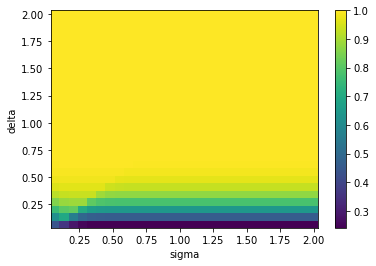

In [18]:
I["gaussian"].plot()

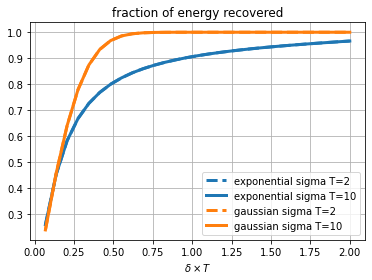

In [22]:
colors = {m: c for m, c in zip(models, ['tab:blue','tab:orange'])}

ax = plt.subplot(111)

for m, da in I.items():
    da.sel(sigma=2., method='nearest').plot(color=colors[m], lw=3, ls='--',
                                            ax=ax, label=m+' sigma T=2')
    da = da.assign_coords(delta_over_sigma=da.delta/10.)
    da.sel(sigma=10., method='nearest').plot(color=colors[m], lw=3, 
                                             ax=ax, label=m+' sigma T=10')

ax.legend()
ax.set_title("fraction of energy recovered")
ax.set_xlabel(r"$\delta \times T$")

ax.grid()


**Conclusion:** 

90% of the total variance is recovered if the filter bandwidth is:

- $1/T$ for exponential autocorrelations
- $1/3T$ (approx) for gaussian shapes
